# 악플 분류기 - 다중분류
- 데이터: https://github.com/smilegate-ai/korean_unsmile_dataset

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기
train_df = pd.read_csv("/content/unsmile_train_v1.0.tsv",delimiter='\t')
test_df = pd.read_csv("/content/unsmile_valid_v1.0.tsv", delimiter='\t')

In [3]:
print(train_df.shape, test_df.shape)
train_df.head(3)

(15005, 12) (3737, 12)


,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0


## 데이터 전처리

- train dataset

In [ ]:
# Null 값 체크
train_df.isna().sum().sum()

0

In [4]:
# 중복 데이터 확인
print(train_df.shape, train_df.문장.nunique())

# 중복 데이터 제거
train_df.drop_duplicates(subset=['문장'], inplace=True)
train_df.shape

(15005, 12) 15004


(15004, 12)

In [5]:
# 분류가 안되어 있는 데이터 확인
print(train_df[train_df.sum(axis=1) == 0].index)

# 분류 안되어 있는 데이터 삭제
train_df = train_df[train_df.sum(axis=1) != 0]

Int64Index([5876, 11942], dtype='int64')


- test dataset

In [ ]:
# Null 값 체크
test_df.isna().sum().sum()

0

In [ ]:
# 중복 데이터 확인
test_df.shape, test_df.문장.nunique()

((3737, 12), 3737)

In [ ]:
# 분류가 안되어 있는 데이터 확인
test_df[test_df.sum(axis=1) == 0]

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭


## 텍스트 전처리

- train data

In [6]:
# 한글 이외의 문자는 공백으로 처리하고 strip
train_df.문장 = train_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.문장.replace('', np.nan, inplace=True)
print(train_df.문장.isna().sum())
train_df.dropna(how='any', inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df.shape

24


(14978, 12)

- test data

In [7]:
# 한글 이외의 문자는 공백으로 처리하고 strip
test_df.문장 = test_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.문장.replace('', np.nan, inplace=True)
print(test_df.문장.isna().sum())
test_df.dropna(how='any', inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.shape

7


(3730, 12)

- 데이터 분포

In [ ]:
train_df.sum()[1:]

여성/가족    1599
남성       1347
성소수자     1140
인종/국적    1727
연령        603
지역       1052
종교       1181
기타 혐오     569
악플/욕설    3141
clean    3718
개인지칭      315
dtype: object

In [ ]:
test_df.sum()[1:]

여성/가족    393
남성       334
성소수자     280
인종/국적    426
연령       146
지역       260
종교       290
기타 혐오    134
악플/욕설    785
clean    930
개인지칭      74
dtype: object

## 악플 데이터만 추출

In [8]:
train_df = train_df[train_df['clean'] ==0]
test_df = test_df[test_df['clean'] ==0]

In [9]:
train_df = train_df.iloc[:, :10]
test_df = test_df.iloc[:, :10]

- 이중 레이블 나누기
- 레이블 열 생성

In [10]:
# 라벨링
df = pd.concat([train_df['문장'], train_df.iloc[:, 1:] * range(1, 10)], axis=1)

dataset_train = pd.DataFrame()
for i in range(1, 10):
  data = df.loc[df.iloc[:, i] > 0][['문장', df.columns[i]]]
  data.columns = ['문장', '라벨']
  dataset_train = pd.concat([dataset_train, data])
  
  dataset_train.reset_index(drop=True, inplace=True)

- 오버 샘플링

In [11]:
x = dataset_train['문장'].values.reshape(-1, 1)
y = dataset_train.iloc[:, 1:].values

In [12]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(x, y)

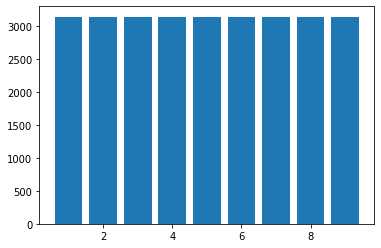

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

counter = Counter(y_resampled)
plt.bar(counter.keys(), counter.values())
plt.show()

## 한글 형태소 분석

In [14]:
# Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 23.65 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 610 kB/s 
     |████████████████████████████████| 453 kB 71.0 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-06-10 04:11:39--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (b

In [15]:
from konlpy.tag import Mecab
from tqdm.notebook import tqdm

In [16]:
mecab = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [17]:
train_data = []
for sentence in tqdm(X_resampled):
  morphs = mecab.morphs(sentence[0])
  tmp_X = [word for word in morphs if word not in stopwords]
  train_data.append(tmp_X)

  0%|          | 0/28269 [00:00<?, ?it/s]

In [18]:
test_data = []
for sentence in tqdm(train_df.문장):
  morphs = mecab.morphs(sentence)
  tmp_X = [word for word in morphs if word not in stopwords]
  test_data.append(tmp_X)

  0%|          | 0/11260 [00:00<?, ?it/s]

## 토큰화

In [19]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(train_data)

In [21]:
# 등장 빈도가 3 미만인 것의 갯수
threshold = 3
total_cnt = len(t.word_index)   # 단어의 수
rare_cnt = 0                    # 등장 빈도가 threshold 보다 작은 단어의 갯수
total_freq = 0                  # 훈련 데이터의 전체 단어의 빈도수의 합
rare_freq = 0                   # 등장 빈도가 threshold 보다 작은 단어의 등장 빈도수의 합

In [22]:
for key, value in t.word_counts.items():
  total_freq += value
  if value < threshold:
    rare_cnt += 1
    rare_freq += value

In [23]:
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 16999
등장 빈도가 2번 이하인 희귀 단어의 수: 5923
단어 집합에서 희귀 단어의 비율: 34.843226072121894
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5931996532973676


In [24]:
# 모든 단어 사용
vocab_size = total_cnt + 2
vocab_size

17001

In [25]:
t = Tokenizer(num_words=vocab_size, oov_token='OOV')
t.fit_on_texts(train_data)
X_train = t.texts_to_sequences(train_data)
X_test = t.texts_to_sequences(test_data)

In [26]:
# 데이터의 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(74, 18.202341787824118)

In [27]:
# 악플 길이를 60으로 설정
max_len = 60

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

X_train.shape, X_test.shape

((28269, 60), (11260, 60))

In [29]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_resampled)
Y_train = np.delete(Y_train, 0, 1)
Y_test = train_df.iloc[:, 1:].values
Y_train.shape, Y_test.shape

((28269, 9), (11260, 9))

## 모델 정의/설정/학습

In [30]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 셀프 어텐션

### 멀티 헤드 어텐션
- 트랜스포머 인코더의 첫번째 서브층

In [31]:
import tensorflow as tf

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

### 인코더 설계하기
- 두번째 서브칭인 포지션 와이즈 피드 포워드 신경망 추가

In [33]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

### 포지션 임베딩
- 임베딩 층을 사용하되, 위치 벡터 학습하도록 임베딩 층의 첫번째 인자로 단어 집합의 크기가 아니라 문장의 최대 길이를 넣어줌

In [35]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### 데이터 전처리

In [34]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

### 모델 정의/학습

In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
del model

In [37]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(9, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 token_and_position_embeddin  (None, 60, 32)           545952    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 60, 32)           6464      
 merBlock)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [38]:
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
model_path = 'best-transforemr-attention.h5py'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=3)

history = model.fit(X_train, Y_train, validation_split=0.2,
                    batch_size=32, epochs=100, callbacks=[mc, es])

Epoch 1/100
704/707 [============================>.] - ETA: 0s - loss: 1.6237 - accuracy: 0.4289
Epoch 1: val_loss improved from inf to 2.20515, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 14s 13ms/step - loss: 1.6213 - accuracy: 0.4299 - val_loss: 2.2051 - val_accuracy: 0.3154
Epoch 2/100
703/707 [============================>.] - ETA: 0s - loss: 0.8651 - accuracy: 0.7405
Epoch 2: val_loss improved from 2.20515 to 1.70118, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 9s 13ms/step - loss: 0.8645 - accuracy: 0.7406 - val_loss: 1.7012 - val_accuracy: 0.4381
Epoch 3/100
707/707 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.8205
Epoch 3: val_loss improved from 1.70118 to 1.45883, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 10s 13ms/step - loss: 0.5894 - accuracy: 0.8205 - val_loss: 1.4588 - val_accuracy: 0.4807
Epoch 4/100
704/707 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.8614
Epoch 4: val_loss improved from 1.45883 to 1.17514, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 10s 14ms/step - loss: 0.4492 - accuracy: 0.8614 - val_loss: 1.1751 - val_accuracy: 0.5522
Epoch 5/100
706/707 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8785
Epoch 5: val_loss improved from 1.17514 to 0.79776, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 9s 12ms/step - loss: 0.3720 - accuracy: 0.8784 - val_loss: 0.7978 - val_accuracy: 0.7009
Epoch 6/100
706/707 [============================>.] - ETA: 0s - loss: 0.3217 - accuracy: 0.8876
Epoch 6: val_loss did not improve from 0.79776
707/707 [==============================] - 6s 8ms/step - loss: 0.3217 - accuracy: 0.8875 - val_loss: 0.8460 - val_accuracy: 0.6816
Epoch 7/100
700/707 [============================>.] - ETA: 0s - loss: 0.2844 - accuracy: 0.8971
Epoch 7: val_loss did not improve from 0.79776
707/707 [==============================] - 5s 8ms/step - loss: 0.2841 - accuracy: 0.8972 - val_loss: 0.8947 - val_accuracy: 0.6800
Epoch 8/100
707/707 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.9041
Epoch 8: val_loss improved from 0.79776 to 0.75997, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 8s 12ms/step - loss: 0.2574 - accuracy: 0.9041 - val_loss: 0.7600 - val_accuracy: 0.7055
Epoch 9/100
707/707 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9048
Epoch 9: val_loss did not improve from 0.75997
707/707 [==============================] - 5s 8ms/step - loss: 0.2474 - accuracy: 0.9048 - val_loss: 0.7806 - val_accuracy: 0.6701
Epoch 10/100
702/707 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9103
Epoch 10: val_loss improved from 0.75997 to 0.66565, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 9s 12ms/step - loss: 0.2293 - accuracy: 0.9105 - val_loss: 0.6657 - val_accuracy: 0.6935
Epoch 11/100
703/707 [============================>.] - ETA: 0s - loss: 0.2262 - accuracy: 0.9079
Epoch 11: val_loss improved from 0.66565 to 0.57509, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 8s 12ms/step - loss: 0.2264 - accuracy: 0.9079 - val_loss: 0.5751 - val_accuracy: 0.7046
Epoch 12/100
704/707 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9111
Epoch 12: val_loss did not improve from 0.57509
707/707 [==============================] - 5s 7ms/step - loss: 0.2152 - accuracy: 0.9110 - val_loss: 0.6086 - val_accuracy: 0.7122
Epoch 13/100
704/707 [============================>.] - ETA: 0s - loss: 0.2038 - accuracy: 0.9128
Epoch 13: val_loss did not improve from 0.57509
707/707 [==============================] - 5s 8ms/step - loss: 0.2036 - accuracy: 0.9130 - val_loss: 0.7060 - val_accuracy: 0.6873
Epoch 14/100
707/707 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9132
Epoch 14: val_loss improved from 0.57509 to 0.50486, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 9s 12ms/step - loss: 0.2007 - accuracy: 0.9132 - val_loss: 0.5049 - val_accuracy: 0.7163
Epoch 15/100
703/707 [============================>.] - ETA: 0s - loss: 0.1979 - accuracy: 0.9148
Epoch 15: val_loss improved from 0.50486 to 0.47967, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 8s 12ms/step - loss: 0.1976 - accuracy: 0.9150 - val_loss: 0.4797 - val_accuracy: 0.7239
Epoch 16/100
704/707 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9154
Epoch 16: val_loss did not improve from 0.47967
707/707 [==============================] - 5s 8ms/step - loss: 0.1891 - accuracy: 0.9155 - val_loss: 0.4809 - val_accuracy: 0.7191
Epoch 17/100
704/707 [============================>.] - ETA: 0s - loss: 0.1890 - accuracy: 0.9162
Epoch 17: val_loss did not improve from 0.47967
707/707 [==============================] - 5s 8ms/step - loss: 0.1891 - accuracy: 0.9162 - val_loss: 0.5705 - val_accuracy: 0.7076
Epoch 18/100
702/707 [============================>.] - ETA: 0s - loss: 0.1822 - accuracy: 0.9175
Epoch 18: val_loss did not improve from 0.47967
707/707 [==============================] - 5s 8ms/step - loss: 0.1821 - accuracy: 0.9175 - val_loss: 0.5254 - val_accuracy: 0.6993


In [39]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

352/352 [==============================] - 2s 4ms/step - loss: 0.1870 - accuracy: 0.9650


[0.18701282143592834, 0.9650088548660278]

In [ ]:
import re

def sentiment_predict(review, best_model,tokenizer=t, max_len=max_len):
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',review).strip()
    morphs = mecab.morphs(review)
    morphs = [word for word in morphs if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([morphs])
    padded = pad_sequences(encoded, maxlen=max_len)
    score = best_model.predict(padded)
    class_text = test_df.columns[1:]

    return print(f"'{review}'\n {score[0][score.argmax()]*100}%의 확률로 {class_text[score.argmax()]}에 대한 악플입니다.")

In [ ]:
num=1210
text = test_df['문장'][num]
print(sentiment_predict(text, best_model,tokenizer=t, max_len=max_len))
print(test_df.loc[num])

'근데 아프가니스탄은 이슬람권 국가중에서도 거의 막장수준이라    다른국가 히잡안쓰는애들도 꽤 많음'
 62.24408149719238%의 확률로 인종/국적에 대한 악플입니다.
None
문장       근데 아프가니스탄은 이슬람권 국가중에서도 거의 막장수준이라    다른국가 히잡안쓰는...
여성/가족                                                    0
남성                                                       0
성소수자                                                     0
인종/국적                                                    1
연령                                                       0
지역                                                       0
종교                                                       0
기타 혐오                                                    0
악플/욕설                                                    0
Name: 1210, dtype: object
